In [1]:
import copy
import sys 
import numpy as np
import matplotlib.pyplot as plt 

sys.path.insert(0, "../qml_src/")

from qml import qcnn as q
from qml import layers as cl # custom layers 


In [2]:
## read / import data 
num_qubits = 9
training_fname = "./data/dataset_n=9_train.txt"
test_fname = "./data/dataset_n=9_test.txt"

def read_eigenvectors(file):
    with open(file, 'r+') as f:
        textData = f.readlines()

        h_vals = []
        for i in range(len(textData)):
            h1h2, eigenvector = textData[i].split("_")

            h_vals.append(tuple(map(float, h1h2[1: -1].split(', '))))
            textData[i] = eigenvector

        return h_vals, np.loadtxt(textData, dtype=complex)

h1h2_train, train_data = read_eigenvectors(training_fname)
h1h2_test, test_data = read_eigenvectors(test_fname)

labels = np.zeros(40)

for index, h1h2 in enumerate(h1h2_train):
    h1, h2 = h1h2
    if h1 <= 1: 
        labels[index] = 1.0


In [4]:
## Model 
my_qcnn = q.Qcnn(num_qubits)

## Add Custom layer: 
legacy_fully_connected_layer = cl.get_legacy_fc_layer(num_qubits // 3)  # because we will be pooling out 2/3 of the qubits 
my_qcnn.Layers[legacy_fully_connected_layer.name] = legacy_fully_connected_layer # we have to add it to our model class variable


## def structure: 
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv4_layer"], kwargs={"label":"C4_1"} )
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], kwargs={"label": "C2"})
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], kwargs={"label": "C3", "start_index": 1})
my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], kwargs={"label": "C4", "start_index": 2})
my_qcnn.add_layer(my_qcnn.Layers["legacy_pool_layer"], kwargs={"label": "P1", 
                                                               "update_active_qubits": {"group_len": 3, "target": 1}})
                                                              # after this we have pooled out 2 out of every 3 qubits 

my_qcnn.add_layer(my_qcnn.Layers[legacy_fully_connected_layer.name], kwargs={})  # this is the custom layer we added earlier ! 

## Initialize parameters: 
my_qcnn.initialize_params(random=True)
initial_params = copy.deepcopy(my_qcnn.params)

## visual check : 
# circ = my_qcnn.generate_circ(my_qcnn.params)
# circ.draw(reverse_bits=True)

In [5]:
## Learning as described in paper: 
learning_rate = 100000  # intial value was 10 but this quantity doesn't learn fast enough ! 
successive_loss = 1.0 # initialize to arbitrary value > 10^-5
loss_lst = []  # initialize 
iteration_num = 1 

while (abs(successive_loss) > 1e-5) and (iteration_num < 1000):
    pred = my_qcnn.forward(train_data, my_qcnn.params.copy())
    loss = my_qcnn.mse_loss(pred, labels)
    
    print("---- Iteration : {}, Loss {} ----------------------".format(iteration_num, loss))
    
    if iteration_num == 1:
        pass 
    
    else: 
        successive_loss = loss - loss_lst[-1]       
        if successive_loss < 0: 
            learning_rate *= 1.05  # if loss decreases, increase learning rate by 5%
        else:
            learning_rate /= 2  # if it gets bigger, decrease learning rate by 50% 
            
    grad_mat = my_qcnn.compute_grad(train_data, labels)
#     grad_mat = my_qcnn.compute_grad_w_mp(train_data, labels)  # with multi processing 
    my_qcnn.update_params(grad_mat, learning_rate)
    
    loss_lst.append(loss)
    iteration_num += 1 
    
# params = copy.deepcopy(my_qcnn.params)

---- Iteration : 1, Loss 0.6552768253752539 ----------------------
---- Iteration : 2, Loss 0.6543942828409385 ----------------------
---- Iteration : 3, Loss 0.6534749453583529 ----------------------
---- Iteration : 4, Loss 0.6525169937368773 ----------------------
---- Iteration : 5, Loss 0.6515197735633647 ----------------------
---- Iteration : 6, Loss 0.6504811796759334 ----------------------
---- Iteration : 7, Loss 0.6494000808210854 ----------------------
---- Iteration : 8, Loss 0.6482757794975483 ----------------------
---- Iteration : 9, Loss 0.6471073562108755 ----------------------
---- Iteration : 10, Loss 0.6458929283110505 ----------------------
---- Iteration : 11, Loss 0.6446320918540124 ----------------------
---- Iteration : 12, Loss 0.643322949550641 ----------------------
---- Iteration : 13, Loss 0.6419649807600315 ----------------------
---- Iteration : 14, Loss 0.6405564285900425 ----------------------
---- Iteration : 15, Loss 0.6390965165911384 -------------

KeyboardInterrupt: 

In [7]:
# print(params)  ## extracting parameters to save future training time 

In [6]:
## Using model on test data (graph visualization) :
predictions = my_qcnn.forward(test_data, my_qcnn.params.copy())
print('got predictions!')

got predictions!


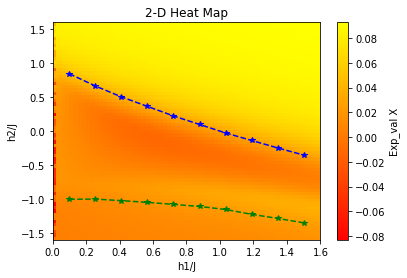

In [7]:
pred_mat = predictions.reshape((64, 64), order='F')
h1_vals = np.linspace(0, 1.6, 64)
h2_vals = np.linspace(-1.6, 1.6, 64)

# plot heat map 
heat_map = plt.pcolormesh(h1_vals, h2_vals, pred_mat, cmap = 'autumn')
plt.colorbar(heat_map, label="Exp_val X")
plt.title( "2-D Heat Map" )
plt.xlabel('h1/J')
plt.ylabel('h2/J')

# plot phase boundaries
h1_vals = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

plt.plot(h1_vals, anti_ferro_mag_boundary, "g--*", label="Antiferromagnetics")
plt.plot(h1_vals, para_mag_boundary, "b--*", label="Paramagnetic")

plt.show()

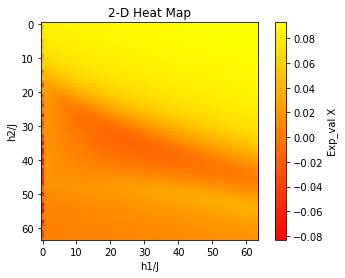

In [8]:
flipped_pred_mat = predictions.reshape((64, 64), order='F')
pred_mat = []
for row_index in np.arange(len(flipped_pred_mat) - 1, -1, -1):
    pred_mat.append(flipped_pred_mat[row_index])

pred_mat = np.array(pred_mat)

heat_map = plt.imshow(pred_mat, cmap = 'autumn', interpolation = 'nearest')
plt.colorbar(heat_map, label="Exp_val X")
plt.title( "2-D Heat Map" )
plt.xlabel('h1/J')
plt.ylabel('h2/J')

# plot phase boundaries
# h1_vals = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
# anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
# para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

# plt.plot(h1_vals, anti_ferro_mag_boundary, "g--*", label="Antiferromagnetics")
# plt.plot(h1_vals, para_mag_boundary, "b--*", label="Paramagnetic")

plt.show()


In [9]:
# print(initial_params)  

In [10]:
## heat_map for initial params (graph visualization) :
initial_predictions = my_qcnn.forward(test_data, initial_params)
print('got predictions!')

got predictions!


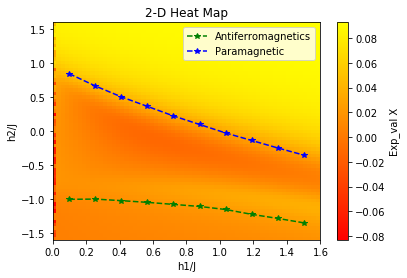

In [11]:
pred_mat = initial_predictions.reshape((64, 64), order='F')
h1_vals = np.linspace(0, 1.6, 64)
h2_vals = np.linspace(-1.6, 1.6, 64)

# plot heat map 
heat_map = plt.pcolormesh(h1_vals, h2_vals, flipped_pred_mat, cmap = 'autumn')
plt.colorbar(heat_map, label="Exp_val X")
plt.title( "2-D Heat Map" )
plt.xlabel('h1/J')
plt.ylabel('h2/J')

# plot phase boundaries
h1_vals = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

plt.plot(h1_vals, anti_ferro_mag_boundary,"g--*", label="Antiferromagnetics")
plt.plot(h1_vals, para_mag_boundary, "b--*", label="Paramagnetic")

plt.legend()
plt.show()

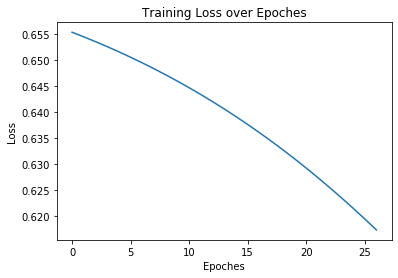

In [12]:
## Loss plot: 
x_axis = range(len(loss_lst))

plt.plot(x_axis, loss_lst)
plt.title('Training Loss over Epoches')
plt.xlabel('Epoches')
plt.ylabel("Loss")
plt.show()